## Task 1 >>>>>>   (open and close the left or right fist) ---> subject_id [3,7,11]

In [1]:
import mne
import numpy as np
import os
from lpt import LPT
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from glob import glob
from mne.io import concatenate_raws
from sklearn.decomposition import FastICA 
from scipy.linalg import eigh
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout, Permute, Conv1D, Conv2D, BatchNormalization, Activation, AveragePooling2D, Reshape, MaxPooling1D, MaxPooling2D
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score,confusion_matrix

In [2]:
import random # Shuffle the list in-place
random.seed(1)

all_paths = glob(os.path.join('data', '**', '*.edf'), recursive=True)
task1_03_paths = [path for path in all_paths if '03' in path.split('\\')[2][5:7]]
random.shuffle(task1_03_paths)
task1_03_paths = task1_03_paths[:100]
task1_07_paths = [path for path in all_paths if '07' in path.split('\\')[2][5:7]]
random.shuffle(task1_07_paths)
task1_07_paths = task1_07_paths[:100]
task1_11_paths = [path for path in all_paths if '11' in path.split('\\')[2][5:7]]
random.shuffle(task1_11_paths)
task1_11_paths = task1_11_paths[:105]
physionet_paths = task1_03_paths + task1_07_paths + task1_11_paths

In [4]:
%%capture  
# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto',verbose='WARNING').set_eeg_reference()
        for path in physionet_paths]

parts = [part.resample(sfreq=128) for part in parts]


In [5]:
# Concatenate them
raw = concatenate_raws(parts)
# Find the events in this dataset
events, _ = mne.events_from_annotations(raw) 

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [ ]:
# Find the events in this dataset
events, _ = mne.events_from_annotations(raw) 

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

Used Annotations descriptions: ['T0', 'T1', 'T2']


<ipython-input-133-1600eb99b42e>:1: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id=dict(left=2, right=3), sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


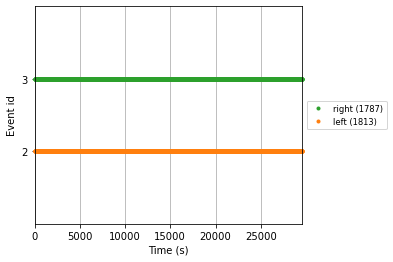

In [ ]:
mne.viz.plot_events(events, event_id=dict(left=2, right=3),tmin=-0.5, tmax=0.5, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
plt.show()

In [10]:
epoched = mne.Epochs(raw, events, dict(left=2, right=3), tmin=0.1, tmax=1.5, proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)

Not setting metadata
4522 matching events found
No baseline correction applied
Using data from preloaded Raw for 4522 events and 180 original time points ...
0 bad epochs dropped


In [13]:
epoched.equalize_event_counts(dict(left=2, right=3))

Dropped 18 epochs: 254, 597, 616, 899, 1002, 1841, 1886, 1909, 1914, 2199, 2216, 2261, 2366, 2475, 2482, 2499, 2912, 3119


(<Epochs |  4504 events (all good), 0.101562 – 1.5 s, baseline off, ~395.9 MB, data loaded,
  'left': 2252
  'right': 2252>,
 array([ 254,  597,  616,  899, 1002, 1841, 1886, 1909, 1914, 2199, 2216,
        2261, 2366, 2475, 2482, 2499, 2912, 3119], dtype=int64))

In [11]:
epoched.get_data().shape

(4522, 64, 180)

In [11]:
epoched.events[:,-1]

array([3, 2, 2, ..., 2, 3, 2])

In [14]:
# Pytorch expects float32 for input and int64 for labels.
X = (epoched.get_data() * 1e6).astype(np.float32)
y = (epoched.events[:,-1] - 2).astype(np.int64)
y

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [15]:
from sklearn.preprocessing import normalize

for i in range(X.shape[0]):

    X[i] = normalize(X[i], axis=0, norm = 'max')
X = (X+1)/2

In [16]:
y.shape , X.shape # no of epochs(samples), channels, length of signal

((4504,), (4504, 64, 180))

In [17]:
X_t = np.transpose(X, (0, 2, 1))
X_t.shape

(4504, 180, 64)

In [136]:
num_samples = X.shape[0]
num_channels = 64 # reduce the channels numbers from 64 to 25
signal_length = X.shape[2]

# Reshape EEG data for preprocessing
reshaped_data = X.reshape(num_samples, -1)

# Apply ICA
ica = FastICA(n_components=num_channels,algorithm='deflation', max_iter=800)
ica_result = ica.fit_transform(reshaped_data)

# Apply SOBI
cov_matrix = np.cov(ica_result, rowvar=False)
eigenvalues, eigenvectors = eigh(cov_matrix)
sobi_result = np.dot(ica_result, eigenvectors)

C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [137]:
# Apply CWT (using PyWavelets library)
def apply_cwt(signal):
    wavelet = 'morl'  # Morlet wavelet
    scales = np.arange(1, 151)  
    cwt_result, _ = pywt.cwt(signal, scales, wavelet)
    return cwt_result

# Apply CWT to each sample in the SOBI result
cwt_results = np.array([apply_cwt(sample) for sample in sobi_result])

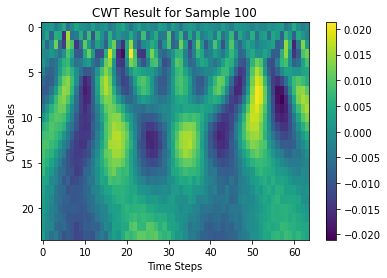

In [138]:
# Visualize an example CWT result
sample_index = 100
plt.imshow(cwt_results[sample_index], aspect='auto', cmap='viridis')
plt.title('CWT Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [139]:
cwt_results.shape, sobi_result.shape, ica_result.shape

((3600, 24, 64), (3600, 64), (3600, 64))

In [22]:
def local_binary_count(pixel_values, center_value):
    binary_values = (pixel_values >= center_value).astype(int)
    decimal_values = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_values

def local_neighbor_descriptive_count(pixel_values):
    binary_values = (pixel_values[:-1] >= pixel_values[1:]).astype(int)
    decimal_values = np.sum(binary_values * 2**(len(pixel_values)-2 - np.arange(len(binary_values))))
    return decimal_values

def local_gradient_count(pixel_values, center_value):
    gradient_values = np.abs(pixel_values - center_value)
    average_gradient = np.mean(gradient_values)
    binary_values = (gradient_values >= average_gradient).astype(int)
    decimal_value = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_value


In [24]:
# Applying transformations to the CWT output
transformed_output = np.zeros((cwt_results.shape[0], cwt_results.shape[1], cwt_results.shape[2], 3), dtype=int)  # Create an array to store the transformed values

for i in range(cwt_results.shape[0]):
    for j in range(cwt_results.shape[1]):
        for k in range(cwt_results.shape[2]):
            pixel_values = cwt_results[i, j, :]
            center_value = pixel_values[k]

            lbc_decimal = local_binary_count(pixel_values, center_value)
            lndc_decimal = local_neighbor_descriptive_count(pixel_values)
            lgc_decimal = local_gradient_count(pixel_values, center_value)

            transformed_output[i, j, k] = [lbc_decimal,lndc_decimal,lgc_decimal]

In [25]:
transformed_output.shape

(3600, 14, 64, 3)

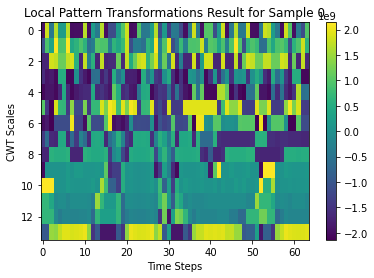

In [26]:
# Choose an index for each technique
lbc_index = 0
lndc_index = 1
lgc_index = 2

combined_transform = (
    transformed_output[:, :, :, lbc_index] +
    transformed_output[:, :, :, lndc_index] +
    transformed_output[:, :, :, lgc_index]
)
# Visualize an example CWT result
sample_index = 0
plt.imshow(combined_transform[sample_index], aspect='auto', cmap='viridis')
plt.title('Local Pattern Transformations Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [18]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2,shuffle= True ,random_state=44)

In [73]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), recurrent_dropout=0.3, return_sequences=True))
# model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.4))  # Dropout for regularization
model.add(LSTM(16, recurrent_dropout=0.3, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/25
113/113 [==============================] - 49s 366ms/step - loss: 0.6070 - accuracy: 0.6508 - val_loss: 0.4780 - val_accuracy: 0.7580
Epoch 2/25
113/113 [==============================] - 48s 427ms/step - loss: 0.4705 - accuracy: 0.7669 - val_loss: 0.4627 - val_accuracy: 0.7714
Epoch 3/25
113/113 [==============================] - 52s 458ms/step - loss: 0.4386 - accuracy: 0.7927 - val_loss: 0.4354 - val_accuracy: 0.7869
Epoch 4/25
113/113 [==============================] - 51s 450ms/step - loss: 0.4198 - accuracy: 0.8016 - val_loss: 0.4250 - val_accuracy: 0.7847
Epoch 5/25
113/113 [==============================] - 51s 450ms/step - loss: 0.4093 - accuracy: 0.8099 - val_loss: 0.4255 - val_accuracy: 0.7958
Epoch 6/25
113/113 [==============================] - 48s 420ms/step - loss: 0.3948 - accuracy: 0.8127 - val_loss: 0.4162 - val_accuracy: 0.7936
Epoch 7/25
113/113 [==============================] - 49s 437ms/step - loss: 0.3862 - accuracy: 0.8204 - val_loss: 0.4067 - val_ac

In [74]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

29/29 [==============================] - 3s 91ms/step - loss: 0.3928 - accuracy: 0.8346


Test accuracy: 0.834628164768219
Kappa: 0.6692470108822856
F1 Score: 0.836801752464403
Precision: 0.8268398268398268
Recall: 0.8470066518847007


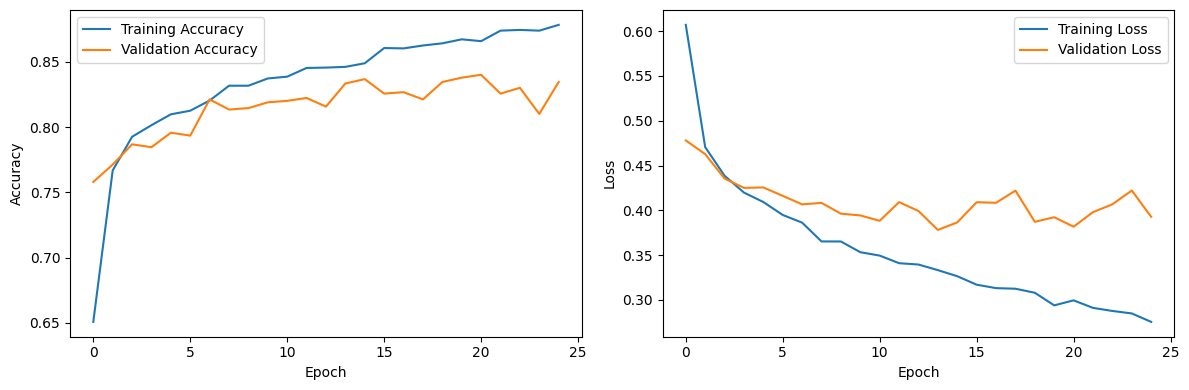

In [75]:
print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

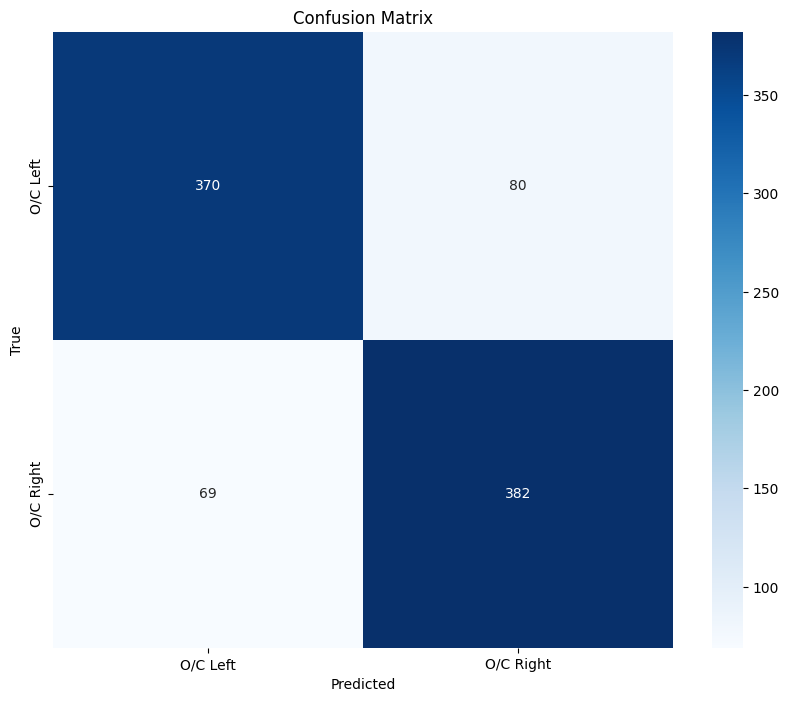

In [76]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [61]:
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Flatten())
# model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification
opt = Adam(learning_rate=0.0005)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Bi = model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/25
226/226 [==============================] - 342s 1s/step - loss: 0.4807 - accuracy: 0.7721 - val_loss: 0.4495 - val_accuracy: 0.7769
Epoch 2/25
226/226 [==============================] - 303s 1s/step - loss: 0.4018 - accuracy: 0.8129 - val_loss: 0.4708 - val_accuracy: 0.7913
Epoch 3/25
226/226 [==============================] - 309s 1s/step - loss: 0.3818 - accuracy: 0.8243 - val_loss: 0.4118 - val_accuracy: 0.8002
Epoch 4/25
226/226 [==============================] - 359s 2s/step - loss: 0.3615 - accuracy: 0.8385 - val_loss: 0.4472 - val_accuracy: 0.7780
Epoch 5/25
226/226 [==============================] - 327s 1s/step - loss: 0.3676 - accuracy: 0.8360 - val_loss: 0.4201 - val_accuracy: 0.8013
Epoch 6/25
226/226 [==============================] - 325s 1s/step - loss: 0.3383 - accuracy: 0.8507 - val_loss: 0.4103 - val_accuracy: 0.8169
Epoch 7/25
226/226 [==============================] - 302s 1s/step - loss: 0.3317 - accuracy: 0.8504 - val_loss: 0.4090 - val_accuracy: 0.8091

29/29 [==============================] - 4s 126ms/step - loss: 0.5665 - accuracy: 0.8213
Test accuracy: 0.8213096857070923
Kappa: 0.64263031733401
F1 Score: 0.8188976377952755
Precision: 0.8310502283105022
Recall: 0.8070953436807096


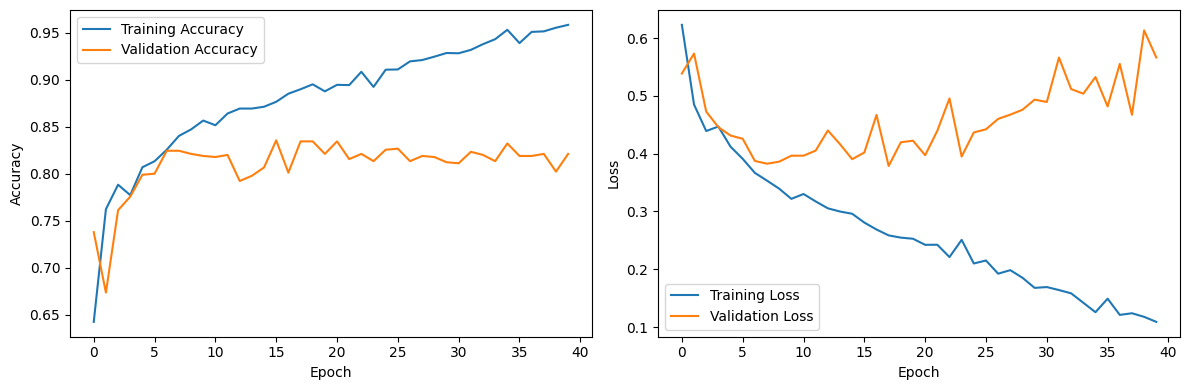

In [38]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_Bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Bi.history['loss'], label='Training Loss')
plt.plot(history_Bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

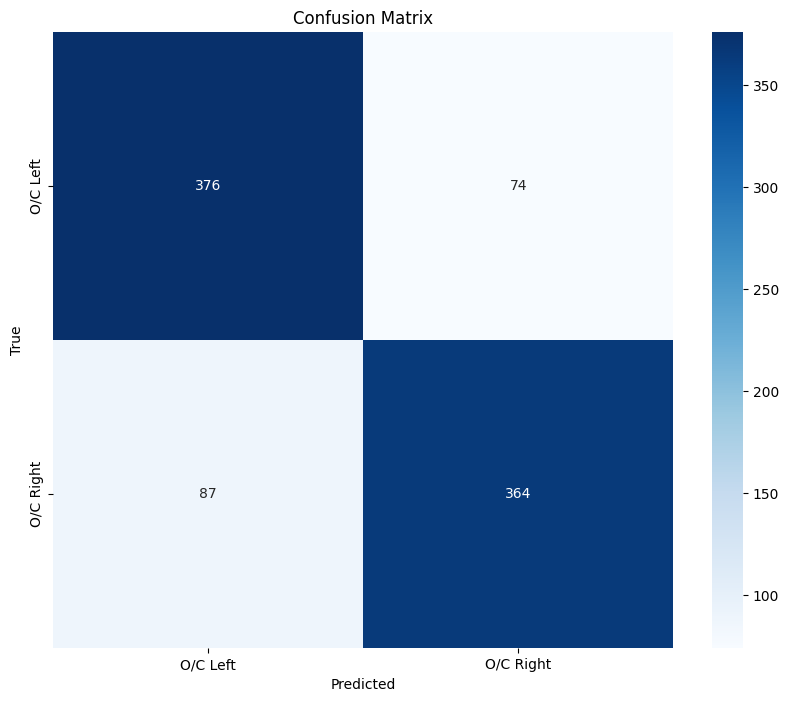

In [39]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Define the Deep Neural Network (DNN) model
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))  # Flatten the CWT data
# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_dnn = model.fit(x_train, y_train, epochs=70, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/70
57/57 [==============================] - 2s 28ms/step - loss: 0.8826 - accuracy: 0.5112 - val_loss: 0.6846 - val_accuracy: 0.5061
Epoch 2/70
57/57 [==============================] - 1s 25ms/step - loss: 0.6785 - accuracy: 0.5662 - val_loss: 0.6788 - val_accuracy: 0.5139
Epoch 3/70
57/57 [==============================] - 1s 22ms/step - loss: 0.6941 - accuracy: 0.5032 - val_loss: 0.6933 - val_accuracy: 0.5006
Epoch 4/70
57/57 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 5/70
57/57 [==============================] - 1s 22ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 6/70
57/57 [==============================] - 1s 21ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 7/70
57/57 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 8/70
57

29/29 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4994


C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy: 0.4994450509548187
Kappa: 0.0
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


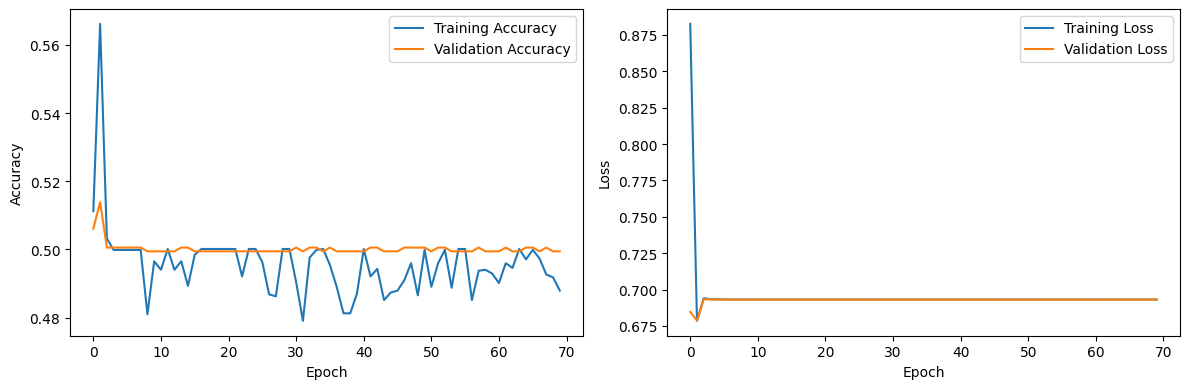

In [29]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

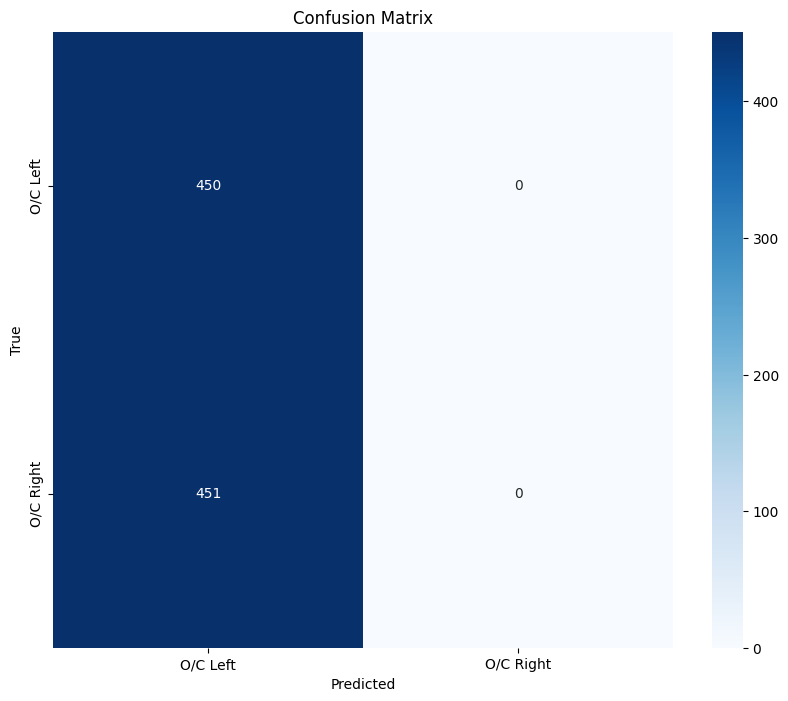

In [30]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(32, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/50
113/113 [==============================] - 3s 15ms/step - loss: 0.7061 - accuracy: 0.5110 - val_loss: 0.6927 - val_accuracy: 0.5161
Epoch 2/50
113/113 [==============================] - 1s 12ms/step - loss: 0.6779 - accuracy: 0.5767 - val_loss: 0.6192 - val_accuracy: 0.7081
Epoch 3/50
113/113 [==============================] - 1s 12ms/step - loss: 0.5694 - accuracy: 0.7305 - val_loss: 0.4973 - val_accuracy: 0.7492
Epoch 4/50
113/113 [==============================] - 1s 12ms/step - loss: 0.5052 - accuracy: 0.7599 - val_loss: 0.5069 - val_accuracy: 0.7592
Epoch 5/50
113/113 [==============================] - 1s 12ms/step - loss: 0.4902 - accuracy: 0.7707 - val_loss: 0.4873 - val_accuracy: 0.7669
Epoch 6/50
113/113 [==============================] - 1s 13ms/step - loss: 0.4793 - accuracy: 0.7752 - val_loss: 0.4924 - val_accuracy: 0.7614
Epoch 7/50
113/113 [==============================] - 1s 12ms/step - loss: 0.4664 - accuracy: 0.7746 - val_loss: 0.4707 - val_accuracy: 0.7802

29/29 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7925
Test accuracy: 0.7924528121948242
Kappa: 0.5849777447157556
F1 Score: 0.7749699157641395
Precision: 0.8473684210526315
Recall: 0.7139689578713969


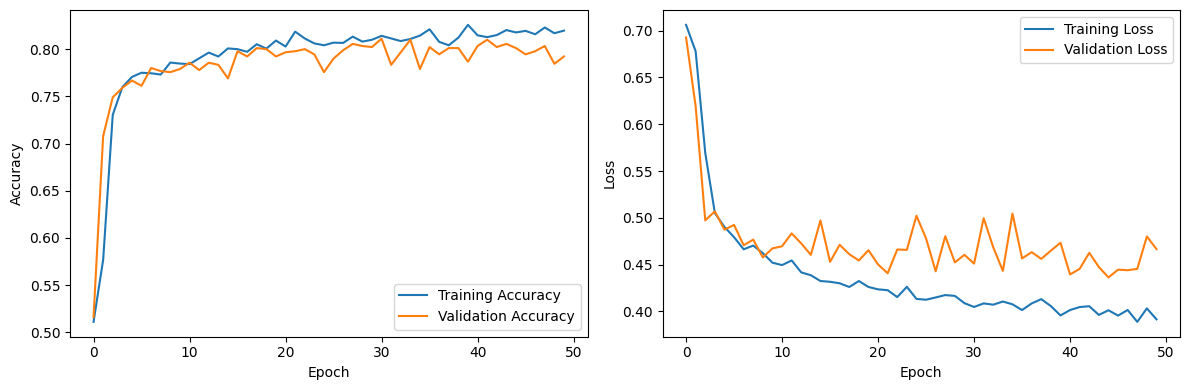

In [32]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

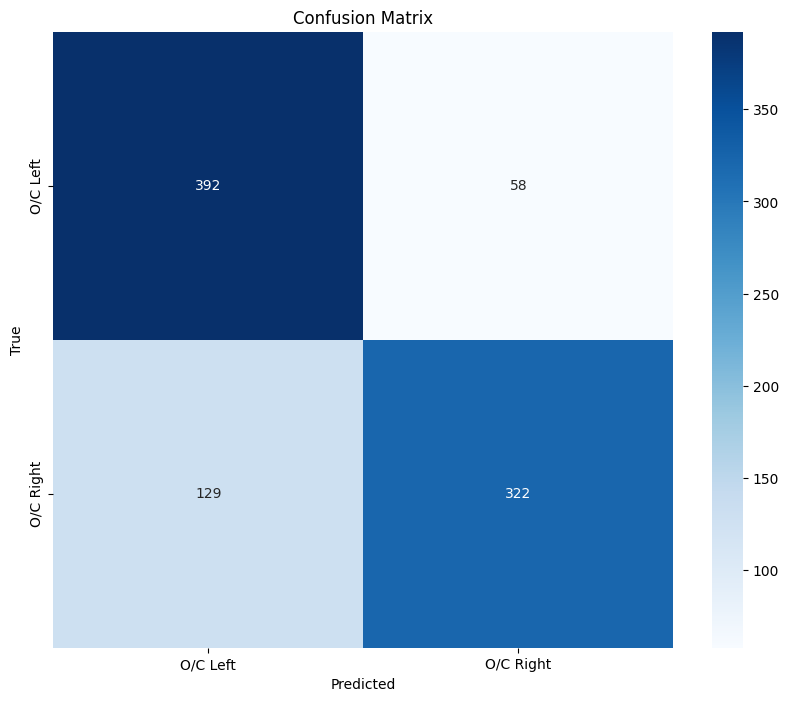

In [33]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [34]:
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Conv1D(32, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    # Flatten(),
    Bidirectional(LSTM(32, recurrent_dropout=0.2, return_sequences=False)),
    Dropout(0.4),
    Dense(10, activation=tf.nn.leaky_relu),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
    ]) 
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_bi = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/40
113/113 [==============================] - 14s 70ms/step - loss: 0.6939 - accuracy: 0.5176 - val_loss: 0.6824 - val_accuracy: 0.5394
Epoch 2/40
113/113 [==============================] - 7s 65ms/step - loss: 0.5991 - accuracy: 0.6986 - val_loss: 0.5497 - val_accuracy: 0.7336
Epoch 3/40
113/113 [==============================] - 8s 70ms/step - loss: 0.5187 - accuracy: 0.7510 - val_loss: 0.5055 - val_accuracy: 0.7691
Epoch 4/40
113/113 [==============================] - 7s 62ms/step - loss: 0.4909 - accuracy: 0.7721 - val_loss: 0.4774 - val_accuracy: 0.7703
Epoch 5/40
113/113 [==============================] - 7s 62ms/step - loss: 0.4676 - accuracy: 0.7818 - val_loss: 0.4760 - val_accuracy: 0.7658
Epoch 6/40
113/113 [==============================] - 7s 59ms/step - loss: 0.4611 - accuracy: 0.7805 - val_loss: 0.4590 - val_accuracy: 0.7825
Epoch 7/40
113/113 [==============================] - 7s 59ms/step - loss: 0.4472 - accuracy: 0.7924 - val_loss: 0.4655 - val_accuracy: 0.773

29/29 [==============================] - 0s 12ms/step - loss: 0.4205 - accuracy: 0.8047
Test accuracy: 0.8046615123748779
Kappa: 0.609366763067009
F1 Score: 0.794392523364486
Precision: 0.8395061728395061
Recall: 0.753880266075388


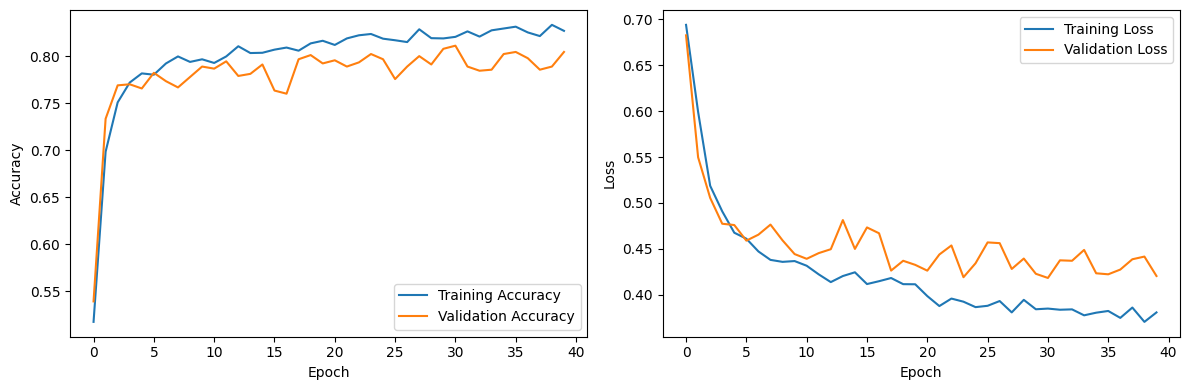

In [35]:
 # Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_bi.history['loss'], label='Training Loss')
plt.plot(history_cnn_bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

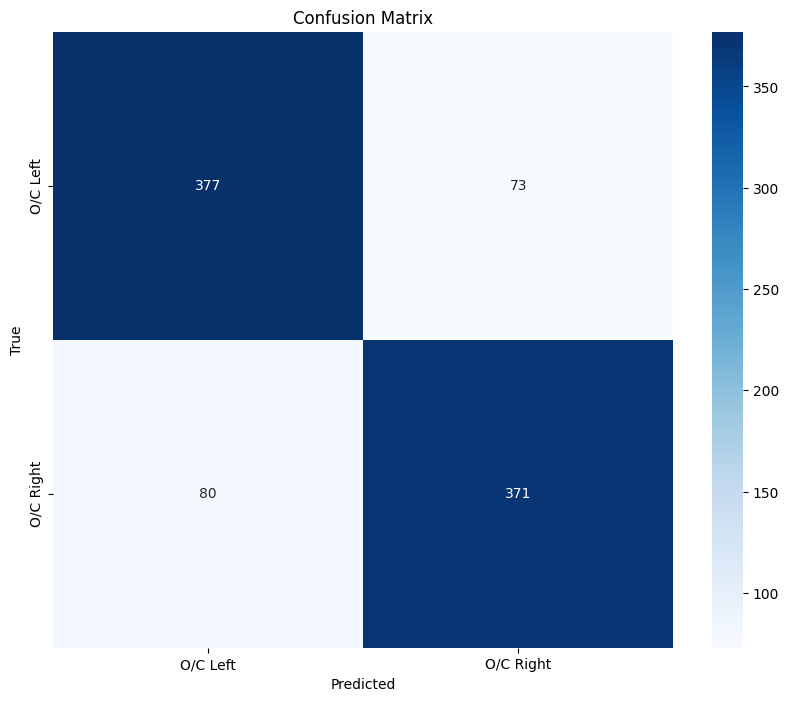

In [62]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [57]:
from tensorflow.keras.layers import GRU
tf.random.set_seed(42)

# Define the advanced 1D CNN model with a GRU layer
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    Dropout(0.3),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    Dropout(0.3),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),
    Dropout(0.3),
    Flatten(),
    # Dense(16, activation='relu'),
    # Dropout(0.35),
    # Dense(16, activation='relu'),
    # Dropout(0.25),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_gru = model.fit(x_train, y_train, epochs=55, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/55
113/113 [==============================] - 38s 165ms/step - loss: 0.6963 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5228
Epoch 2/55
113/113 [==============================] - 17s 154ms/step - loss: 0.6941 - accuracy: 0.4954 - val_loss: 0.6935 - val_accuracy: 0.4994
Epoch 3/55
113/113 [==============================] - 18s 160ms/step - loss: 0.6935 - accuracy: 0.5085 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 4/55
113/113 [==============================] - 19s 167ms/step - loss: 0.6940 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 5/55
113/113 [==============================] - 18s 162ms/step - loss: 0.6937 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5150
Epoch 6/55
113/113 [==============================] - 23s 206ms/step - loss: 0.6933 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5161
Epoch 7/55
113/113 [==============================] - 21s 188ms/step - loss: 0.6935 - accuracy: 0.4868 - val_loss: 0.6931 - val_ac

KeyboardInterrupt: 

29/29 [==============================] - 0s 15ms/step - loss: 0.3802 - accuracy: 0.8302
Test accuracy: 0.8301886916160583
Kappa: 0.6603827970446432
F1 Score: 0.829050279329609
Precision: 0.8355855855855856
Recall: 0.8226164079822617


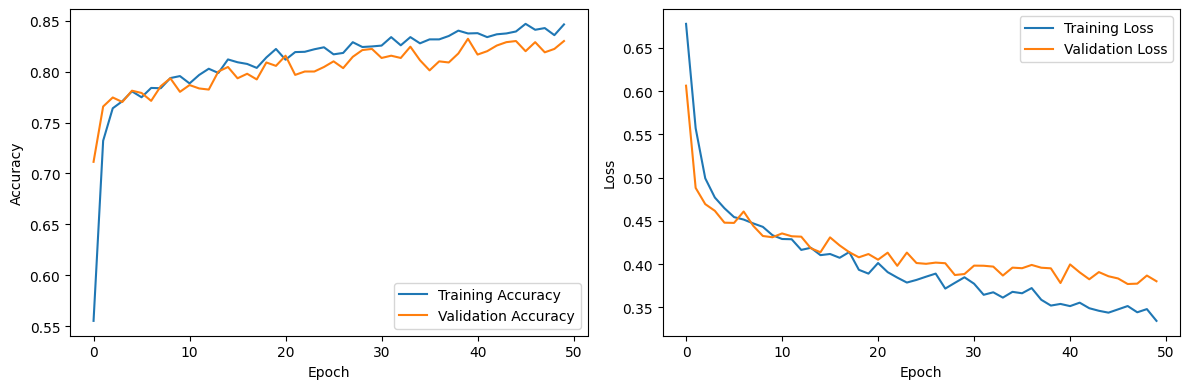

In [52]:
 # Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_gru.history['loss'], label='Training Loss')
plt.plot(history_cnn_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

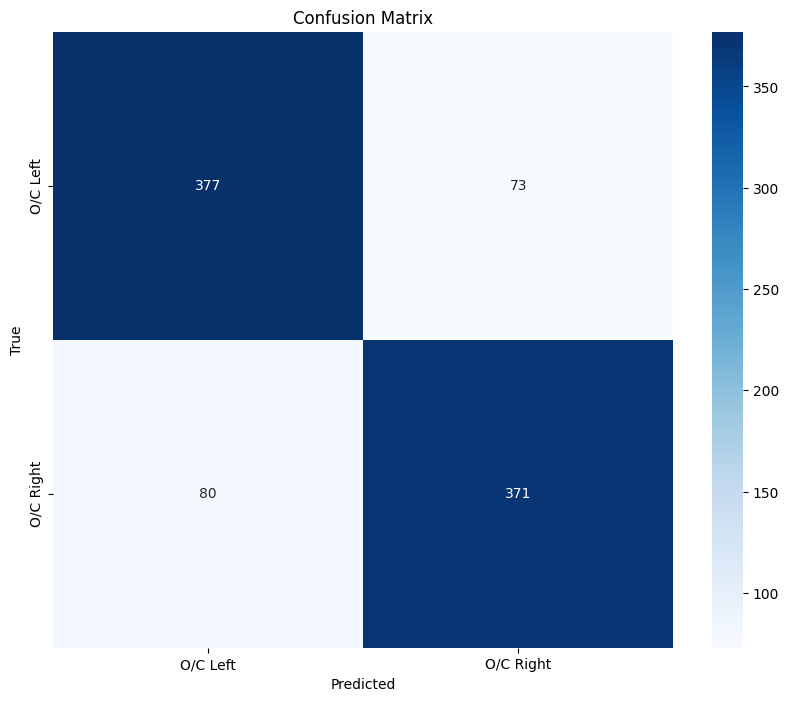

In [53]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()